**Introduction**

This analysis will be looking at Amazon review data acquired using API link. The data for this particular product contains 5,000 reviews and ratings. 

The goal of this project is executed in 2 parts: (1) classify text reviews as positive or negative, and (2) summarize top keywords/phrases for the positive/negative groups. 

Numerical ratings will be used to determine if reviews are negative (1-3) or positive (4-5) for a supervised learning approach. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn import metrics
import seaborn as sb
!pip install langdetect
from langdetect import detect
drive.mount('/content/drive')

**Load, clean data, and prep data.**

In [2]:
#load data
data = pd.read_csv('/content/drive/MyDrive/Thinkful Projects/Capstone IV/data.csv')

In [3]:
#add column to contain the cleaned text and lang detection
data['clean_title'] = ''
data['clean_review'] = ''
data['newRating'] = ''
data['lang'] = ''

#drop na values
data.dropna(inplace = True)

In [4]:
data.head()

,Unnamed: 0,rating,title,Review_text,clean_title,clean_review,newRating,lang
0,0,5,Worked soon as I plugit in,I bought the 4tb Model for 99 bucks for my xbo...,,,,
1,1,1,The single worst product ever produced.,I bought my one touch device at staples. I loa...,,,,
2,2,4,Works good but can be hacked easily.,Buy something more expensive. But they do work...,,,,
3,3,1,Inaccurate Item Description,The item description specifies that it's compa...,,,,
4,4,1,Terrible,"Terrible won't connect to my laptop, Playstati...",,,,


In [5]:
#change name of first column
data.rename(columns={'Unnamed: 0': 'Index'},inplace = True) 

**Remove punctuations and other symbols with regular expressions.**

In [6]:
import re #regular expressions

#removes non signifcant text using regular expressions
def cleanData(text):
    text = re.sub('http\S+\s*', ' ', text)  # remove URLs
    text = re.sub('RT|cc', ' ', text)       # remove RT and cc
    text = re.sub('#\S+', '', text)         # remove hashtags
    text = re.sub('@\S+', '  ', text)       # remove mentions
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', text)  # remove punctuations
    text = re.sub(r'[^\x00-\x7f]',r' ', text) 
    text = re.sub('\s+', ' ', text)         # remove extra whitespace
    return text
data['clean_review'] = data.Review_text.apply(lambda x: cleanData(x)) #replacing empty empty 'cleaned_resume' with cleaned data
data['clean_title'] = data.title.apply(lambda x: cleanData(x)) #replacing empty empty 'cleaned_resume' with cleaned data


In [7]:
#removing empty strings and short strings again for use of lang detect
data.replace(' ', np.nan, inplace=True)
data.replace('100 ', np.nan, inplace=True)
data.dropna(inplace = True)

**Detect language and use only the ones in English.**

In [8]:
#detect language of reviews and store in column

#keep track of the language in column lang
count = 0
for i in range(len(data['clean_review'])):
  data.iloc[i,7] = detect(data.iloc[i,5])
  if detect(data.iloc[i,5]) != 'en':
    count +=1

#keep only rows that are english
data = data[data['lang'] =='en']
print('Number of Non-English reviews:', count)

Number of Non-English reviews: 411


**Convert data: 1-3 is negative (-1) and 4-5 is positive (+1).**

In [9]:
#encoding 4,5 to be 1 (positive), and 1,2,3 ratings to be -1 (negative)
data['newRating'].loc[data['rating']>3] = 1
data['newRating'].loc[data['rating']<=3] = -1
#df.loc[df["gender"] == "male", "gender"] = 1

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


**Simple initial data exploration and visualization to see data distribution.**

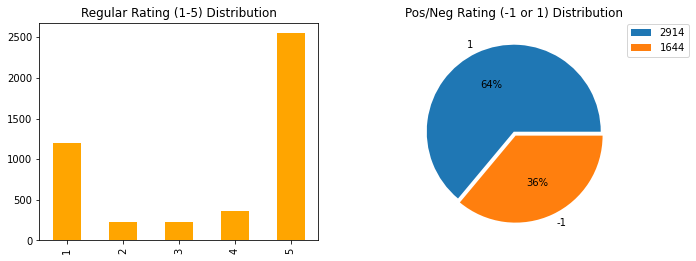

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

rate_order = [1,2,3,4,5]
data['rating'].value_counts().loc[rate_order].plot( kind='bar',ax=axs[0], color = 'orange')
axs[0].title.set_text('Regular Rating (1-5) Distribution')


data['newRating'].value_counts().plot(kind='pie',autopct='%1.0f%%',ax=axs[1],explode=(0, 0.05))
axs[1].title.set_text('Pos/Neg Rating (-1 or 1) Distribution')
axs[1].set(xlabel = '', ylabel="")
axs[1].legend(data['newRating'].value_counts(),bbox_to_anchor=(1, 1.02), loc='upper left')

#data['newRating'].plot.pie(legend=False, autopct='%1.1f%%', explode=(0, 0, 0.1), shadow=True, startangle=0)

**Remove stop words and vectorize reviews using Tf-idf.**

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer 

#split vectorize words and split into test/train
requiredText = data['clean_review'].values
requiredTarget = data[['Index','newRating']].values     #array with the corresponding numerical categories
                                                        #Index added in to relocate original data after vectorize and train_test_split
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=1500)                                  #initializes vectorizer object
word_vectorizer.fit(requiredText)
WordFeatures = word_vectorizer.transform(requiredText)  #transform to sparse term matrix


X_train,X_test,y_tr_w_index,y_te_w_index = train_test_split(WordFeatures,requiredTarget,random_state=0, test_size=0.2) #trains model using subsets using Cross Validation Method
y_train = y_tr_w_index[:,1].astype('int')               #grab target data / cast as int
y_test = y_te_w_index[:,1].astype('int')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


**PART I: Test performance using Random Forest, SVM, and Gradient Boost with 5-fold cross validation on training data then test data (for final result).**

**NOTE:** Dummy classifier was used as a baseline comparison.

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score
import sklearn.metrics as m
from sklearn.dummy import DummyClassifier

#dummy classifier as baseline for comparison
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)   

dummy_clf.score(X_train, y_train) 

0.6396050466264399

In [13]:
#Random Forest
rf_clf = RandomForestClassifier(n_estimators=24)
rf_cv_scores = cross_val_score(rf_clf, X_train, y_train, cv = 5)
rf_clf.fit(X_train, y_train)

print('Accuracy scores for the 5 folds: ', rf_cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(rf_cv_scores)))

#Values for n_estimators were tested from 4 to 38 with ~24 being optimal.

Accuracy scores for the 5 folds:  [0.85068493 0.86419753 0.85322359 0.85733882 0.83264746]
Mean cross validation score: 0.852


In [14]:
#instantiate SVM Classifier
svm_clf = svm.SVC()
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv = 5)
svm_clf.fit(X_train, y_train)
     
print('Score on training data: ', svm_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(svm_scores)))

Score on training data:  [0.87808219 0.89300412 0.89711934 0.88477366 0.89163237]
Mean cross validation score: 0.889


In [15]:
#instantiate Gradient Boost
params = {'n_estimators': 50,
          'max_depth': 15,
          'loss': 'exponential'}

GB_clf = ensemble.GradientBoostingClassifier(**params)
GB_scores = cross_val_score(GB_clf, X_train, y_train, cv = 5)
GB_clf.fit(X_train, y_train)

print('Score on training data: ', GB_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(GB_scores)))

#tested for n_estimators from 30-60, max_depth 10-20, all 3 diff loss functions 
#optimal parameters were 50, 15, and exponential accordingly.

Score on training data:  [0.8369863  0.83676269 0.85733882 0.82578875 0.83127572]
Mean cross validation score: 0.838


**Running all algorithms on remaining test data set with the found optimal parameters.**

In [16]:
rf_pred = rf_clf.predict(X_test)
svm_pred = svm_clf.predict(X_test)
GB_pred = GB_clf.predict(X_test)

score_dat = [['Accuracy', m.accuracy_score(rf_pred,y_test), m.accuracy_score(svm_pred,y_test), m.accuracy_score(GB_pred,y_test)], \
             ['Precision', m.precision_score(rf_pred,y_test), m.precision_score(svm_pred,y_test), m.precision_score(GB_pred,y_test)],\
             ['Recall', m.recall_score(rf_pred,y_test), m.recall_score(svm_pred,y_test), m.recall_score(GB_pred,y_test)]] 
score_table = pd.DataFrame(score_dat,columns=['Metrics','Ran. Forest', 'SVM', 'Grad. Boost'])
score_table.head()

,Metrics,Ran. Forest,SVM,Grad. Boost
0,Accuracy,0.875000,0.898026,0.859649
1,Precision,0.924399,0.934708,0.943299
2,Recall,0.884868,0.908180,0.852484


**Part II: Key phrase/word extraction from the bad reviews and the good reviews** 



In [ ]:
!pip install rake-nltk

**Grab original test set reviews and split into good/bad reviews.**

In [126]:
test_set_ind = y_te_w_index[:,0]                                  #get index of original text in test set                           
og_test_dat = data.loc[test_set_ind,['Review_text','newRating']]  #create dataframe with corresponding reviews and rating 'Review_text'

#separate good reviews from bad reviews
good_rev = og_test_dat.loc[og_test_dat['newRating'] == 1, 'Review_text'].values
bad_rev = og_test_dat.loc[og_test_dat['newRating'] == -1, 'Review_text'].values

**Implement keyword/phrase extraction and scoring using rake.**

In [ ]:
#key phrase extraction using rake
from rake_nltk import Rake

r = Rake(punctuations = [')','(',',',':','),',').','.','-','>','"','|','->','--','=','/',';','&','$','2tb'])

#extract positive and negative phrases
r.extract_keywords_from_sentences(good_rev)
good_phrase_df = pd.DataFrame(r.get_ranked_phrases_with_scores(), columns = ['score','phrase'])
r.extract_keywords_from_sentences(bad_rev)
bad_phrase_df = pd.DataFrame(r.get_ranked_phrases_with_scores(), columns = ['score','phrase'])

**Looking at score distribution to determine at what scores to grab data.**

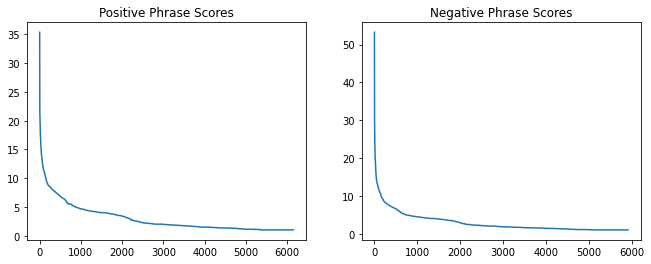

In [133]:
#analyze phrase scores to filter out j
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

good_phrase_df['score'].plot(ax=axs[0])
axs[0].title.set_text('Positive Phrase Scores')
bad_phrase_df['score'].plot(ax=axs[1])
axs[1].title.set_text('Negative Phrase Scores')

**Most valueable phrases appears to occur before the "elbow" when score is greater than 15.**

**NOTE:** first few high scoring phrases could potentially be noise due to unique words being used.

In [144]:
#get top 10 positive phrases
good_phrase_df[good_phrase_df['score']>15].head(10)

,score,phrase
0,35.392308,chrome os flex since google purchased neverware
1,35.107140,good deal low cost per mega fast quiet like
2,28.214286,spinning magnetic discs suspended nanometers away
3,26.839453,external hard drive portable hdd – usb 3
4,25.430492,games transferred really quick cod cold war
5,21.114674,gaming system freeze bought two one worked
6,21.096154,drives failure rates increase close
7,20.982046,previous segate 2 tb hard drive
8,20.392243,handles large mp4 files fairly well
9,20.222222,nvme cache gives amazing density


In [145]:
#get top 10 negative phrase
bad_phrase_df[bad_phrase_df['score']>15].head(10)

,score,phrase
0,53.267740,beeping sounds !!!!! corrupted files !!!!!!!! ...
1,33.538889,random fun failed sunday !!! beyond livid
2,31.722581,luckily another amazon reviewer kindly detaile...
3,30.333333,parent whose kid gets cut open
4,28.845238,microphones headphones keyboard mouse etc ...
5,27.840713,never order another sea gate hard drive
6,26.173077,owner 3 different extended storage devices sim...
7,25.211594,disk still contains sensitive financial inform...
8,23.879805,hard drive last night ad burned
9,23.558376,new 50 dollar hard drive plz


**Summary and Recommendation:** 

SVM was selected since it outperformed the others in performance metrics. It was able to classify the data with accuracy, precision, and recall at .89, .93, and .90. 


The use of this tool can help product owners to continuously monitor customer reviews and improve their product as well as provide customers transparency. 


Recommendations:
(1) Test method on historical data that has positive/negative already annoted. (2) Explore various different keyword/phrase extraction techniques. (3) Provide wordcloud for general idea of word frequency.